<a href="https://colab.research.google.com/github/EduFdezSoy/safety-first/blob/master/six_epochs_original_dropouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety helmet detector

Source: https://www.kaggle.com/ehddnr301/helmet-classification

In [17]:
# Uncomment for install tensorflow 1.15.
!pip install tensorflow==1.15

In [18]:
# Imports
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from skimage import io, transform
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout
# Check Tensorflow version.
tf.version.VERSION

'1.15.0'

## 1. Loading Data

In [19]:
# Uncomment for clonning the repository
!git clone https://github.com/sergiorodenas/ml-data.git

fatal: destination path 'ml-data' already exists and is not an empty directory.


In [20]:
# Image constants
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH1='./ml-data/helmet-dataset/Train_positive/Train_positive/'
PATH2='./ml-data/helmet-dataset/Train_negative/Train_negative/'

In [21]:
# Getting the images
filenames_list_yes = []
filenames_list_no = []

for filename in os.listdir(PATH1):
    filenames_list_yes.append(PATH1 + filename)
    
for filename in os.listdir(PATH2):
    filenames_list_no.append(PATH2 + filename)

df_yes = pd.DataFrame({
    'image': filenames_list_yes,
    'category': np.ones(len(filenames_list_yes), str)
})
df_no = pd.DataFrame({
    'image': filenames_list_no,
    'category': np.zeros(len(filenames_list_no), str)
})
print(df_yes.shape, df_no.shape)
df = df_yes.append(df_no, ignore_index=True)
print(df['image'][0])

(5160, 2) (6580, 2)
./ml-data/helmet-dataset/Train_positive/Train_positive/4325.jpg


## 2. Training data

In [22]:
# Hyperparameters
BATCH_SIZE=32
EPOCHS=20

In [23]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.15, stratify = df['category'], random_state = 3)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
print(train_df.shape)
print(valid_df.shape)

(9979, 2)
(1761, 2)


In [24]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   )

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col = 'image',
                                              y_col = 'category',
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              validate_filenames=False
                                             )

#we do not augment validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_gen = validation_datagen.flow_from_dataframe(
    valid_df, 
    x_col="image",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

Found 9979 non-validated image filenames belonging to 2 classes.
Found 1761 non-validated image filenames belonging to 2 classes.


In [25]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', tf.keras.metrics.Precision()])


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 49, 49, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
dropout_3 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 8)        

## 3. Train the model

In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath = 'mask.weights.best.hdf5', save_best_only = True, save_weights_only = True)
early_stop = EarlyStopping(monitor='loss', patience=3)
callbacks = [learning_rate_reduction, checkpointer, early_stop]

In [28]:
start = time.time()

model.fit_generator(train_gen,
                    epochs = EPOCHS,
                    validation_data = valid_gen,
                    validation_steps=total_valid//BATCH_SIZE,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    callbacks = callbacks)

endTime = time.time() - start
print("Total time: ", endTime, "seconds")

Epoch 1/20
311/311 [==============================] - 13s 41ms/step - loss: 0.1939 - acc: 0.9207 - precision_1: 0.9100 - val_loss: 0.2259 - val_acc: 0.8989 - val_precision_1: 0.9934
Epoch 2/20
311/311 [==============================] - 12s 37ms/step - loss: 0.1030 - acc: 0.9620 - precision_1: 0.9535 - val_loss: 0.1005 - val_acc: 0.9585 - val_precision_1: 0.9821
Epoch 3/20
311/311 [==============================] - 12s 37ms/step - loss: 0.0842 - acc: 0.9695 - precision_1: 0.9626 - val_loss: 0.0835 - val_acc: 0.9716 - val_precision_1: 0.9826
Epoch 4/20
311/311 [==============================] - 11s 37ms/step - loss: 0.0836 - acc: 0.9690 - precision_1: 0.9617 - val_loss: 0.0641 - val_acc: 0.9767 - val_precision_1: 0.9692
Epoch 5/20
311/311 [==============================] - 11s 37ms/step - loss: 0.0730 - acc: 0.9726 - precision_1: 0.9657 - val_loss: 0.0809 - val_acc: 0.9705 - val_precision_1: 0.9478
Epoch 6/20
 55/311 [====>.........................] - ETA: 7s - loss: 0.0779 - acc: 0.9733

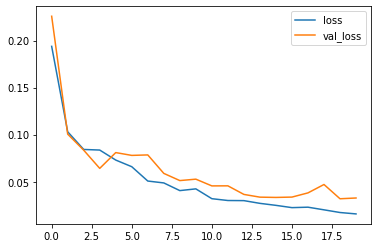

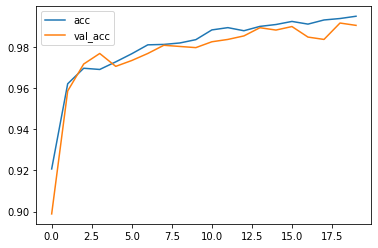

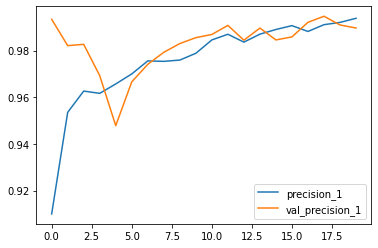

In [32]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['acc', 'val_acc']].plot()
loss[['precision_1', 'val_precision_1']].plot()

In [35]:
loss_mean = loss.mean()
loss_mean

loss               0.051373
acc                0.980396
precision_1        0.975801
val_loss           0.062563
val_acc            0.976733
val_precision_1    0.982649
lr                 0.000513
dtype: float64

In [33]:
print("Epochs: ", EPOCHS)
print("Train time: ", endTime, "seconds") 

Epochs:  20
Train time:  226.29486632347107 seconds


In [37]:
print("| ALGORITMO | {} | {} |  {} |   {} |  {} |      {} | {} |      {} |   {} |     |".format(loss_mean.acc, loss_mean.loss, loss_mean.val_acc, loss_mean.val_loss, loss_mean.precision_1, loss_mean.val_precision_1, loss_mean.lr, len(model.history.epoch), endTime))


| ALGORITMO | 0.980396232008934 | 0.051372701452739 |  0.9767329514026641 |   0.06256261812374841 |  0.9758009612560272 |      0.9826488226652146 | 0.0005125000243424438 |      20 |   226.29486632347107 |     |
